In [3]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils.vis import *
from my_utils import models
from my_utils.utils import check_accuracy
from my_utils.data.dataset import raw_png_processor, raw_video_processor, MyDataset, split_dataset
from my_utils.data.loader import load_frames
from my_utils.data.preprocess import sub_mean, reduce

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:0" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.12.0+cu113
There are 1 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='NVIDIA A100-SXM4-80GB', major=8, minor=0, total_memory=81251MB, multi_processor_count=108)
CUDA version: 11.3
Using cuda:5 now!
torch version: 1.12.0+cu113
There are 1 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='NVIDIA A100-SXM4-80GB', major=8, minor=0, total_memory=81251MB, multi_processor_count=108)
CUDA version: 11.3
Using cuda:0 now!


In [53]:
png_abs_dir = '/mnt/lustre/wangyihao/nlos_raw_pngs/train/Being hit_p0_r0_grey_tiling_07-16-15-49'
frames = load_frames(png_abs_dir, frame_range=(0, 64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


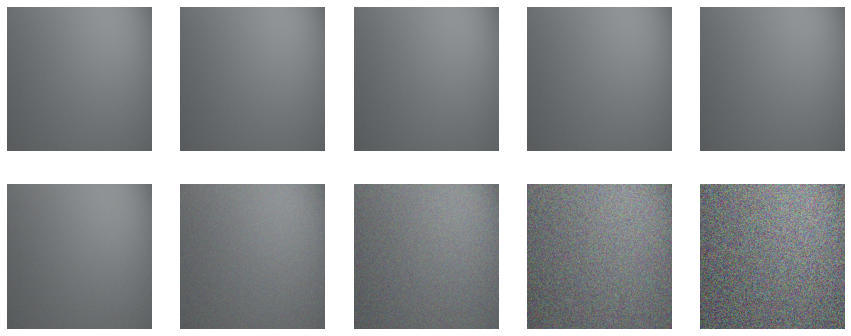

In [54]:
plt.figure(figsize=(15, 6))
noise_factor = [0.01, 0.03, 0.05, 0.1, 0.15]
for i, pic in enumerate(frames.cpu()[:,:,:,:3]):
    pic = pic.type(torch.int)
    plt.subplot(2,5,i+1)
    plt.imshow(pic)
    plt.axis('off')

    noisy_pic = pic + 255 * noise_factor[i] * torch.randn_like(pic, dtype=torch.float)
    noisy_pic = noisy_pic.type(torch.int)
    plt.subplot(2,5,i+6)
    plt.imshow(noisy_pic)
    plt.axis('off')


In [16]:
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 64)),
        # transforms.Normalize(mean, std)
    # transforms.ColorJitter(brightness=.1, hue=.1)
])

In [3]:
dataset = MyDataset(
    dataset_root='/mnt/lustre/wangyihao/nlos_raw_pngs/train/',
    modal='video',
    mat_name='128_N0',
    # raw_data_root='/mnt/cfs/wangyh/blender/blank_wall/output_random/',
    reduce_mode='W',
    transform=None
)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
len(loader.dataset)
# print(unseen_loader.dataset[0][0].shape)

Loading dataset:


100%|██████████| 1601/1601 [01:38<00:00, 16.25it/s]


1600

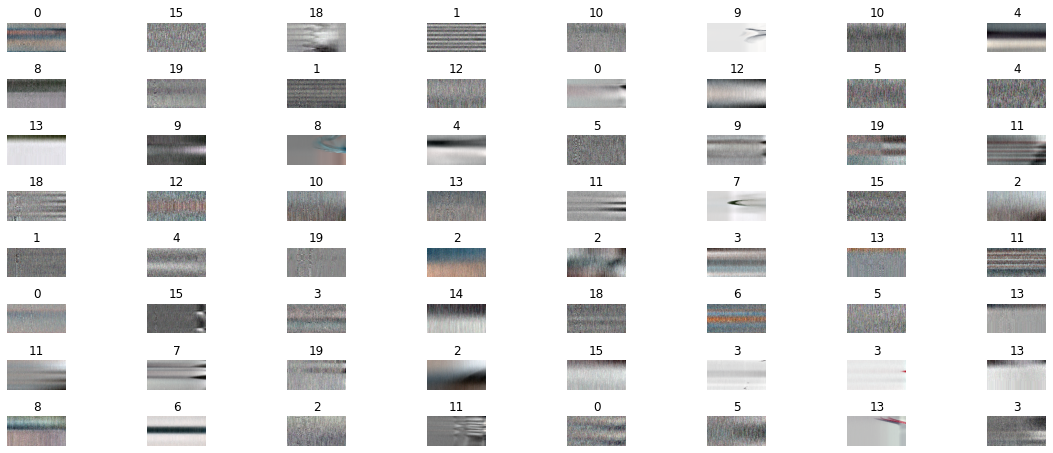

In [19]:
grid_vis(loader, row_num=8, multiply=5)

In [109]:
model = models.NLOS_Conv(num_classes=10, depths=(4,1), dims=(16,32), kernel_size=7).to(device)
checkpoint = torch.load('/home/wangyh/01-Projects/01-NLOS/test_runs/2022_05_21_19_06_34/checkpoints/best.pth')
new_state_dict = {k.replace('module.',''):v for k,v in checkpoint['model'].items()}
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [110]:
m = check_accuracy(model, loader)

1it [00:00,  2.75it/s]

Test accuracy is : 16.67%	Infer time: 0.36664581298828125


In [108]:
checkpoint['best_val_acc']

tensor(0.8927, device='cuda:0')

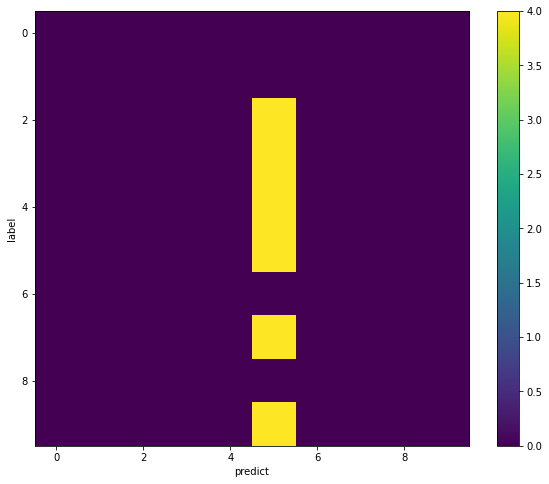

In [111]:
# plt.figure(figsize=np.array(m.shape) * 1.5)
plt.imshow(m, cmap='viridis')
plt.ylabel('label')
plt.xlabel('predict')
plt.colorbar()

In [4]:
inputs, labels = next(iter(loader))
print(inputs.shape)
print(labels)

torch.Size([64, 3, 64, 128, 128])
tensor([ 1,  0,  9, 14,  0,  4,  7,  8,  7, 10,  5,  2, 19,  6, 19,  7, 15,  2,
         7, 12, 15,  5,  3,  1, 18,  8, 19, 14,  5, 11,  4,  6,  2, 18, 13,  2,
         4,  8, 15, 15,  9, 12,  3,  3, 10,  1,  1,  2, 18, 12, 14, 14,  8,  1,
         4, 11,  2,  0,  6, 16, 18,  0,  2,  3])


In [10]:
device = torch.device(f"cuda:0")
my_r21d_model = models.NLOS_r21d(layers=[1,2], channels=[16, 32]).to(device)

In [11]:
my_r21d_model.eval()
loss, preds = my_r21d_model((inputs.to(device), labels.to(device)))
print(loss, preds)

tensor(3.0014, device='cuda:0', grad_fn=<NllLossBackward0>) tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12], device='cuda:0')


In [2]:
png_abs_dir = '/mnt/lustre/wangyihao/nlos_raw_pngs/train/Being hit_p0_r0_grey_tiling_07-16-15-49'
frames = load_frames(png_abs_dir, frame_range=(0, 64))
print(frames.shape)

torch.Size([64, 256, 256, 3])


In [5]:
from my_utils.vis import frame2video

video_save_path = '/mnt/lustre/wangyihao/cache_home/01-Projects/NLOS/output/Being hit_p0_r0_grey_tiling_07-16-15-49.mp4'
frame2video(frames, video_save_path)

100%|██████████| 64/64 [00:00<00:00, 468.52it/s]

Successfully write frames into /mnt/lustre/wangyihao/cache_home/01-Projects/NLOS/output/Being hit_p0_r0_grey_tiling_07-16-15-49.mp4!


In [8]:
train_dataset, val_dataset = split_dataset(
    dataset_root='/mnt/lustre/wangyihao/nlos_raw_pngs/train',
    modal='video',
    cls_mode='action',
    phase='train',
    ratio=0.8,
    reduced_mode='H',
    mat_name='128_N0',
    transform=None)

100%|██████████| 1601/1601 [01:41<00:00, 15.80it/s]


In [9]:
len(train_dataset)

1280